# crawl post list

In [ ]:
l_1 = get_link(urllib.parse.quote('크리스마스 데이트'))
l_2 = get_link(urllib.parse.quote('크리스마스 가볼만한곳'))

# with open('./rawdata/post/list_2.txt', 'w') as f:
#     f.write(get_all_posts(l_2))
# with open('./rawdata/post/list_1.txt', 'w') as f:
#     f.write(get_all_posts(l_1))

with open('./rawdata/post/list_1.html', 'r') as f:
    html_1 = f.read()
with open('./rawdata/post/list_2.html', 'r') as f:
    html_2 = f.read()

post_list_1, _ = get_post_list(html_1)
post_list_2, _ = get_post_list(html_2)

posts_1 = [parse_post(post) for post in post_list_1]
posts_2 = [parse_post(post) for post in post_list_2]
post_df_1 = pd.DataFrame(posts_1, columns=COLUMNS)
post_df_2 = pd.DataFrame(posts_2, columns=COLUMNS)
post_df_1['keyword'] = pd.Series(list(['크리스마스 데이트'] * len(post_df_1)))
post_df_2['keyword'] = pd.Series(list(['크리스마스 가볼만한곳'] * len(post_df_2)))

post_df = pd.concat([post_df_1, post_df_2])

post_df['volume_no']= post_df.comment_link.apply(lambda l: int(re.search(r'volumeNo=(\d+)', l).group(1)))
post_df['member_no']= post_df.comment_link.apply(lambda l: int(re.search(r'memberNo=(\d+)', l).group(1)))
post_df['owner_followers'] = post_df.member_no.apply(parse_post_owner_info)

post_df = drop_cols(post_df, ['comment_link', 'link', 'series_link', 'owner_link'])

post_df.to_csv('./gendata/post/list.csv', index_label=False)
print(len(post_df))
post_df.head()

In [5]:
post_df = pd.read_csv('./gendata/post/list.csv', index_col=False)
with open('./rawdata/post/list_3.html', 'r') as f:
    html_3 = f.read()
post_list_3, _ = get_post_list(html_3)
posts_3 = [parse_post(post) for post in post_list_3]
post_df_3 = pd.DataFrame(posts_3, columns=COLUMNS)
post_df_3['keyword'] = pd.Series(list(['크리스마스 축제'] * len(post_df_3)))

post_df_3['volume_no']= post_df_3.comment_link.apply(lambda l: int(re.search(r'volumeNo=(\d+)', l).group(1)))
post_df_3['member_no']= post_df_3.comment_link.apply(lambda l: int(re.search(r'memberNo=(\d+)', l).group(1)))
post_df_3['owner_followers'] = post_df_3.member_no.apply(parse_post_owner_info)

post_df_3 = drop_cols(post_df_3, ['comment_link', 'link', 'series_link', 'owner_link'])


post_df = pd.concat([post_df, post_df_3])
post_df.head()

/Users/ShinAhnjae/anaconda3/envs/data_py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: use options instead of chrome_options


,owner_name,date,read_num,like,comment_num,series_name,title,keyword,volume_no,member_no,owner_followers
0,0,내일뭐하지,2018.11.28.,88149.0,114,7,시리즈 내일 여행가자!,"서울 크리스마스 데이트, 당일치기 데이트 코스 5곳",크리스마스 데이트,17201653,11556787
1,1,마을기업 진흥캠페인,2018.12.14.,570.0,44,3,시리즈 우리동네 마을축제,크리스마스데이트 가기 좋은 곳,크리스마스 데이트,17335759,33893934
2,2,메가북스,2018.11.28.,45366.0,63,10,NaN,미리 메리 크리스마스-★ 크리스마스 데이트 장소 추천 5,크리스마스 데이트,17196395,38694016
3,3,호텔스컴바인,2018.11.20.,13941.0,15,1,시리즈 국내호텔 탐방기,"부산 크리스마스 데이트, 연말여행 장소! 겨울부산여행 호텔",크리스마스 데이트,17135753,3543910
4,4,한화,2018.12.03.,2446.0,7,2,시리즈 한화 뉴스룸,크리스마스 데이트 추천! 63빌딩에서 만나는 Lifeplus 윈터원더랜드!,크리스마스 데이트,17232134,1972196


In [21]:
post_df = pd.read_csv('./gendata/post/list.csv')
post_df = pd.concat([post_df, post_df_3])
print(len(post_df))
new_post_df = post_df.drop_duplicates(subset=['member_no', 'volume_no'])
new_post_df.to_csv('./gendata/post/list_new.csv', index_label=False)

8060


In [29]:
import os
import json
import urllib
import multiprocessing
import pandas as pd
import sys
import time
import json
import re
import numpy as np

DRIVER_PATH = '/Users/ShinAhnjae/Desktop/3-2/DataJournalism/drivers'
sys.path.append(DRIVER_PATH)

from bs4 import BeautifulSoup
from selenium import webdriver
from datetime import datetime
from functools import reduce, lru_cache
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

COLUMNS = [
    'owner_link', 'owner_name', 'date', 'read_num', 
    'like', 'comment_link', 'comment_num',
    'series_link', 'series_name', 'link', 'title',
]

def drop_cols(df, cols):
    columns = df.columns
    for col in cols:
        if col in columns:
            df = df.drop(col, axis=1)
    return df

def get_link(keyword):
    url = (
        'https://m.post.naver.com/search/post.nhn'
        '?keyword={keyword}&sortType=rel.dsc&range=20120101000000:20181215235959'
        '&term=custom&navigationType=current'
    ).format(keyword=keyword)
    return url

def get_all_posts(l):
    driver = webdriver.Firefox(executable_path='/Users/ShinAhnjae/Desktop/3-2/DataJournalism/drivers/geckodriver')
    driver.get(l)

    SCROLL_PAUSE_TIME = 0.5

    old_height = driver.execute_script("return document.body.scrollHeight")
    while True:

        element = WebDriverWait(driver, 20).until(EC.element_to_be_clickable((By.XPATH, "/html/body/div[2]/div[2]/div/div[5]/button")))
        element.click()

        time.sleep(2)
        new_height = driver.execute_script("return document.body.scrollHeight")
        print(new_height)
        if old_height == new_height:
            break
        if new_height >= 600000:
            break

        old_height = new_height
    html = driver.page_source
    return html

def get_post_list(html):
    dom = BeautifulSoup(html)
    body = dom.find('div', id='wrap').find('div', id='cont').find('div', class_='search_result_wrap result_page')

    num_posts = int(body.find('div', class_='sorting_area t2').find('em').text.replace(',', ''))
    post_lists = body.find_all('ul', class_='lst_feed')
    post_list = []
    for pl in post_lists:
        post_list.extend(pl.find_all('li'))
    return post_list, num_posts

# https://m.post.naver.com/my.nhn?memberNo=11556787 : post 주인
def parse_post(post):
    post_header = post.find('div', class_='feed_head')
    post_body = post.find('div', class_='feed_body')
    post_footer = post.find('div', class_='feed_footer')
    
    # parse header
    post_owner_link = post_header.find('a')['href']
    post_owner_name = post_header.find('p', class_='writer').find('a').find('span').text
    post_info = post_header.find('div', class_='info_post')
    post_date = post_info.find('time').text.strip()
#     post_date = datetime.strptime(post_date, "%Y.%m.%d.")
    post_read_num = post_info.find('span', class_='view_post')
    if post_read_num:
        post_read_num = int(post_read_num.text.split(" ")[0].strip().replace(',', ''))
    
    # parse body
    post_like = int(post_footer.find('div', class_='btn_like').find('em', class_='u_cnt _cnt').text.strip().replace(',', ''))
    post_comments = post_footer.find('div', class_='float_right').find('a', class_='btn_reply')
    post_comment_link = post_comments['href']
    post_comment_num = int(post_comments.find('em').text.strip().replace(',', ''))
    
    # parse footer
    post_body_text = post_body.find('div', class_='text_area')
    post_series_link = post_body_text.find('a', class_='series_title')
    if post_series_link:
        post_series_link = post_series_link['href']
    post_series_name = post_body_text.find('a', class_='series_title')
    if post_series_name:
        post_series_name = post_series_name.find('div').text.strip()
    post_link = post_body_text.find('a', class_='link_end')['href']
    post_title = post_body_text.find('a', class_='link_end').find('strong', class_='tit_feed ell').text.strip()
    
    return (
        post_owner_link, post_owner_name, post_date, post_read_num, 
        post_like, post_comment_link, post_comment_num,
        post_series_link, post_series_name, post_link, post_title,
    )


def get_full_page(url):
    options = webdriver.ChromeOptions()
    options.add_argument('headless')
    options.add_argument('window-size=1920x1080')
    options.add_argument("disable-gpu")
    # 혹은 options.add_argument("--disable-gpu")
    DRIVER_PATH = '/Users/ShinAhnjae/Desktop/3-2/DataJournalism/drivers/chromedriver'
    driver = webdriver.Chrome(executable_path=DRIVER_PATH, chrome_options=options)
    driver.get(url)
    try:
        html = driver.page_source
    except Exception as e:
        html = None
        print(e)
    return html


def get_content_info(content):
    content_type = content['class']
    content_type_major = content_type[1]
    if content_type_major in ('se_image', 'se_imageStrip', 'se_oglink'):
        content_info = None
    elif content_type_major == 'se_quotation':
        content_info = content.find('blockquote').text
    elif content_type_major == 'se_paragraph':
        content_info = content.find('p', class_='se_textarea')
        if content_info:
            content_info = content_info.text
    elif content_type_major == 'se_map':
        map_data = json.loads(content.find('a', class_='se_map_link __se_link')['data-linkdata'])
        map_title = content.find('div', class_='se_title').text.strip()
        map_addr = content.find('div', class_='se_address').text.strip()
        content_info = map_data, map_title, map_addr
    else:
        content_info = None
    return content_type_major, content_info

def get_card_content_info(content):
    content_type = content['class'][1]
    if content_type == 'se_textCard':
        content_info = content.find('div', class_='se_card_content').text.strip().replace('\n', ' ')
        return 'text', content_info
    
    content_info = None
    anchors = content.findAll('a')
    for anchor in anchors:
        if anchor.has_attr('data-linkdata'):
            if 'longitude' in anchor['data-linkdata']:
                content_info = anchor['data-linkdata']
                return 'map', content_info
    content_info = content.text.strip().replace('\n', ' ')
    return 'text', content_info

def get_post_link(volume_no, member_no):
    return 'https://m.post.naver.com/viewer/postView.nhn?volumeNo={}&memberNo={}'.format(volume_no, member_no)

def get_owner_link(member_no):
    return 'https://m.post.naver.com/my.nhn?memberNo={}'.format(member_no)

def get_comment_link(volume_no, member_no):
    return 'https://m.post.naver.com/viewer/commentsView.nhn?volumeNo={}&memberNo={}'

def parse_post_info(volume_no, member_no):
    print(volume_no, member_no)
    url = get_post_link(volume_no, member_no)
    html = get_full_page(url)
    if not html:
        return None
    dom = BeautifulSoup(html)
#     print(dom)
    post_body = dom.select('div.se_doc_viewer.se_body_wrap')
    if post_body:
        post_body = post_body[0]
        post_title = post_body.select('div.se_component.se_documentTitle')[0]
        post_date = post_title.find('span', class_='se_publishDate').text
        post_view = post_title.find('span', class_='se_view').text

        post_body = dom.find('div', class_='se_component_wrap sect_dsc __se_component_area')
        post_contents = post_body.find_all('div', class_='se_component')

        content_infos = [get_content_info(content) for content in post_contents]
        content_infos = [info for info in content_infos if info[1]]

        text = []
        location = []
        post_date = datetime.strptime(post_date, "%Y.%m.%d. %H:%M")
        post_view = int(post_view.split(' ')[0].strip().replace(',', ''))
        for ctype, content in content_infos:
            if not content:
                continue

            if isinstance(content, str):
                text.append(content)

            elif ctype == 'se_map':
                map_data, map_name, map_addr = content
                y = map_data['latitude']
                x = map_data['longitude']
                location.append((x, y, map_name, map_addr))
            else:
                raise TypeError('%s not recognized' % ctype)
        text = ' '.join(text).replace('\xa0', ' ').replace('●', ' ')

        return post_date, post_view, text, location
    
    post_body = dom.find('div', class_='se_card_container')
    if not post_body:
        return None
    post_contents = post_body.find_all('div', class_='se_card')
    post_head_card = post_contents[0]
    post_contents = post_contents[1:]
    post_head_card = post_head_card.find('div', class_='se_card_cover_wrapView')
    post_head_card = post_head_card.find('div', class_='se_container')
    post_head_card = post_head_card.find('div', class_='se_group').find('p', class_='se_detail')
    post_date = post_head_card.find('span', class_='se_publishDate').text.strip()
    post_view = post_head_card.find('span', class_='se_view').text.strip()
    post_date = datetime.strptime(post_date, "%Y.%m.%d. %H:%M")
    post_view = int(post_view.split(' ')[0].strip().replace(',', ''))

    content_infos = [get_card_content_info(content) for content in post_contents]
    content_infos = [info for info in content_infos if info[1]]

    text = []
    location = []
    for ctype, content in content_infos:
        if not content:
            continue

        if ctype == 'text':
            text.append(content)

        elif ctype == 'map':
            map_data = json.loads(content)
            y = map_data['latitude']
            x = map_data['longitude']
            map_name = map_data['title']
            location.append((x, y, map_name, None))
        else:
            raise TypeError('%s not recognized' % ctype)
    text = ' '.join(text).replace('\xa0', ' ').replace('●', ' ').replace('   ', ' ')

    return post_date, post_view, text, location

OWNER_INFO = {}


@lru_cache()
def parse_post_owner_info(member_no):
    if member_no in OWNER_INFO:
        return OWNER_INFO[member_no]
    url = get_owner_link(member_no)
    html = get_full_page(url)
    dom = BeautifulSoup(html)

    post_owner_body = dom.find('div', id='cont')
    if not post_owner_body:
        OWNER_INFO[member_no] = None
        return None
    post_owner_body = post_owner_body.find('div', class_='expert_num_info')
    post_owner_info  = post_owner_body.find('ul', class_='info_wrap')
    post_owner_followers = post_owner_info.find_all('li')[0]
    post_owner_followers = post_owner_followers.find('a').find('span').text.replace(',', '').strip()
    post_owner_followers = int(post_owner_followers)
    
    OWNER_INFO[member_no] = post_owner_followers
    
    return post_owner_followers

In [146]:
blog_infos = {}
exclude_list = [
    1355, 1182, 1581, 1251, 1387, 1439, 1531, 1031, 1434, 957, 1726, 831, 285, 1373, 1097, 1592, 1531, 1669, 1292, 1170, 603, 1443, 1743, 1713, 1509, 1257, 1045, 1150, 551, 1370, 1283, 1841, 1466, 221]
post_df = pd.read_csv('./gendata/post/list_new.csv')
post_df = post_df.drop(exclude_list, axis=0)
print(len(post_df))

post_df = post_df[~post_df['title'].str.contains("선물")]
post_df = post_df[~post_df['title'].str.contains("해외")]
post_df = post_df[~post_df['title'].str.contains("책")]
post_df = post_df[~post_df['title'].str.contains("부산")]
post_df = post_df[~post_df['title'].str.contains("국내")]
post_df = post_df[~post_df['title'].str.contains("지역별")]
post_df = post_df[~post_df['title'].str.contains("영화")]
post_df = post_df[~post_df['title'].str.contains("전주")]
post_df = post_df[~post_df['title'].str.contains("파리")]
post_df = post_df[~post_df['title'].str.contains("유럽")]
post_df = post_df[~post_df['title'].str.contains("일본")]
post_df = post_df[~post_df['title'].str.contains("후쿠오카")]
post_df = post_df[~post_df['title'].str.contains("데코")]
post_df = post_df[~post_df['title'].str.contains("패션")]
post_df = post_df[~post_df['title'].str.contains("스타일링")]
post_df = post_df[~post_df['title'].str.contains("핀란드")]
post_df = post_df[~post_df['title'].str.contains("프라이데이")]
post_df = post_df[~post_df['title'].str.contains("퀘백")]
post_df = post_df[~post_df['title'].str.contains("이번 주말")]
post_df = post_df[~post_df['title'].str.contains("뉴욕")]
post_df = post_df[~post_df['title'].str.contains("호주")]
post_df = post_df[~post_df['title'].str.contains("남양주")]
post_df = post_df[~post_df['title'].str.contains("해운대")]
post_df = post_df[~post_df['title'].str.contains("롯데리아")]
post_df = post_df[~post_df['title'].str.contains("독일")]
post_df = post_df[~post_df['title'].str.contains("홍콩")]
post_df = post_df[~post_df['title'].str.contains("SBS")]
post_df = post_df[~post_df['title'].str.contains("계천")]
post_df = post_df[~post_df['title'].str.contains("북해도")]
post_df = post_df[~post_df['title'].str.contains("제주도")]
post_df = post_df[~post_df['title'].str.contains("스페인")]
post_df = post_df[~post_df['owner_name'].str.contains("BH엔터테인먼트")]
post_df = post_df[~post_df['owner_name'].str.contains("씨네21")]
post_df = post_df[~post_df['owner_name'].str.contains("리네")]
post_df = post_df[~post_df['owner_name'].str.contains("더퍼스트미디어")]
post_df = post_df[~post_df['owner_name'].str.contains("게티이미지뱅크")]
post_df = post_df[~post_df['owner_name'].str.contains("이상국의 담아드림")]
post_df = post_df[~post_df['owner_name'].str.contains("강원도민일보")]
post_df = post_df[~post_df['owner_name'].str.contains("새로운 남양주")]
post_df = post_df[~post_df['owner_name'].str.contains("문학동네")]
# post_df = post_df[~post_df['series_name'].str.contains("일본")]



print(len(post_df))
# post_df = post_df.query('read_num > 20000')
print(len(post_df))
post_df

3635
2800
2800


,owner_name,date,read_num,like,comment_num,series_name,title,keyword,volume_no,member_no,owner_followers
0,내일뭐하지,2018.11.28.,88149.0,114,7,시리즈 내일 여행가자!,"서울 크리스마스 데이트, 당일치기 데이트 코스 5곳",크리스마스 데이트,17201653,11556787,42148
1,마을기업 진흥캠페인,2018.12.14.,570.0,44,3,시리즈 우리동네 마을축제,크리스마스데이트 가기 좋은 곳,크리스마스 데이트,17335759,33893934,1990
2,메가북스,2018.11.28.,45366.0,63,10,NaN,미리 메리 크리스마스-★ 크리스마스 데이트 장소 추천 5,크리스마스 데이트,17196395,38694016,9646
4,한화,2018.12.03.,2446.0,7,2,시리즈 한화 뉴스룸,크리스마스 데이트 추천! 63빌딩에서 만나는 Lifeplus 윈터원더랜드!,크리스마스 데이트,17232134,1972196,1538
5,에어비앤비,2018.12.12.,3268.0,3,0,시리즈 테마로 떠나는 여행,서울 크리스마스 데이트: 서울 가볼 만한 곳 Best 5,크리스마스 데이트,17307677,34646617,15106
6,브랜디,2018.12.12.,1547.0,2,0,시리즈 브언니의 T.P.O 코디,'레드'로 포인트를 준특별한 크리스마스 데이트룩♥,크리스마스 데이트,17317263,16271204,2561
7,켄싱턴호텔앤리조트,2018.12.13.,435.0,7,1,시리즈 맛집여행,크리스마스에 어디가지? 여의도 연말데이트 장소 추천!,크리스마스 데이트,17325815,8894783,3821
9,더유니브,2017.12.15.,10034.0,63,4,시리즈 핫플레이스 tip,"크리스마스 데이트 코스, 성공적인 종로 고백명소 editor’s pick 3",크리스마스 데이트,11298697,34545175,24153
10,호텔스컴바인,2017.11.28.,75518.0,74,12,시리즈 국내호텔 탐방기,크리스마스 데이트!별빛 예쁜 데이트장소 추천!,크리스마스 데이트,10869921,3543910,13531
11,내일뭐하지,2017.12.13.,133176.0,164,25,시리즈 내일 여행가자!,"서울 크리스마스 데이트 장소 추천, 특별한 하루를 보내기 좋은 곳 4군데",크리스마스 데이트,11248348,11556787,42148


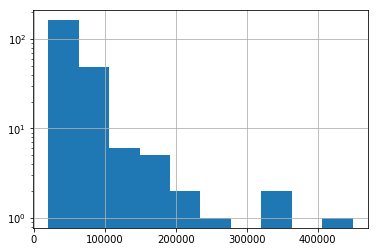

In [117]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
post_df.read_num.hist()
ax.set_yscale('log')

In [147]:
post_df.to_csv('./gendata/post/list_interest.csv', index_label=False)


In [165]:
i = 0
def crawl_posts(post_df):
    for i, (idx, row) in enumerate(post_df.iterrows()):
        print(i, end=" ")
        member_no = row.member_no
        volume_no = row.volume_no
        
        post_id = (member_no, volume_no)
        if post_id in blog_infos:
            print(post_id)
            continue
        
        data = parse_post_info(volume_no, member_no)
        if not data:
            blog_infos[post_id] = None
            continue
        date, read_num, text, location = data
        post_info = {
            'date': date, 'read_num': read_num, 'text': text, 'location': location
        }
        blog_infos[post_id] = post_info

crawl_posts(post_df)

0 (11556787, 17201653)
1 (33893934, 17335759)
2 (38694016, 17196395)
3 (1972196, 17232134)
4 (34646617, 17307677)
5 (16271204, 17317263)
6 (8894783, 17325815)
7 (34545175, 11298697)
8 (3543910, 10869921)
9 (11556787, 11248348)
10 (11556787, 5537847)
11 (38043394, 17217489)
12 (5004021, 17214603)
13 (23519771, 17266584)
14 (3543910, 5792764)
15 (41086796, 17234059)
16 (1457815, 5721068)
17 (808040, 17314870)
18 (28655711, 5801611)
19 (3543910, 17259781)
20 (1460956, 5817541)
21 (22517376, 17308103)
22 (808040, 3168885)
23 (35665182, 17337192)
24 (11031159, 3160100)
25 (16711396, 17300620)
26 (544106, 11193995)
27 (808040, 5821333)
28 (2032633, 10851113)
29 (3574014, 11382130)
30 (42226668, 17306359)
31 (11556787, 5720368)
32 (38979565, 11444648)
33 (23902914, 11464452)
34 (25130036, 5893896)
35 (8946195, 5890084)
36 (24097984, 5880610)
37 (24696651, 11477416)
38 (33531344, 5821532)
39 (187867, 3240816)
40 (30480929, 11407787)
41 (3543910, 17103740)
42 (25130036, 5881984)
43 (25598567, 1

780 (36310338, 16351803)
781 (15305315, 17271927)
782 (9332686, 17066516)
783 (15460571, 17245013)
784 (36610018, 11037274)
785 (6006472, 5872345)
786 (36835023, 11553323)
787 (1023071, 5958770)
788 (37053911, 17284186)
789 (25788480, 5807810)
790 (1162096, 3329466)
791 (31380582, 17334704)
792 (1901247, 10059563)
793 (1120493, 3025856)
794 (25459212, 11540326)
795 (6732124, 3245870)
796 (38070993, 10604768)
797 (24047399, 3229763)
798 (1834, 17077342)
799 (2726287, 5956250)
800 (1901247, 12038021)
801 (12072749, 3195842)
802 (31271347, 5673492)
803 (34127817, 5662850)
804 (15792726, 10904095)
805 (16395423, 5809673)
806 (6130907, 11271636)
807 (25572889, 5920557)
808 (37851782, 11274457)
809 (25735996, 11135009)
810 (8894783, 17235222)
811 (765727, 11414859)
812 (15470144, 11267867)
813 (31236733, 11188278)
814 (423197, 5972294)
815 (3337548, 5879391)
816 (2869918, 5675745)
817 (1518823, 357125)
818 (33304368, 11313357)
819 (15304837, 11251157)
820 (15500600, 3238909)
821 (34545175, 1

1503 (5224193, 5902859)
1504 (17391, 11747619)
1505 (24350634, 5733231)
1506 (9054750, 269834)
1507 (33801958, 11029256)
1508 (34233805, 5806828)
1509 (19457573, 5959708)
1510 (28442918, 5786386)
1511 (16395423, 5599599)
1512 (1607525, 11287000)
1513 (693562, 5786633)
1514 (32530926, 5758710)
1515 (32404124, 16855899)
1516 (4663506, 5937783)
1517 (30808910, 10686259)
1518 (29961208, 11438197)
1519 (2354041, 5982476)
1520 (27556885, 5597695)
1521 (32708900, 11494852)
1522 (3027726, 4096427)
1523 (4728886, 5751445)
1524 (40412127, 13573470)
1525 (8505878, 5880844)
1526 (35263451, 15129352)
1527 (34809420, 5932668)
1528 (36156224, 16955906)
1529 (13286, 5676453)
1530 (566, 10952064)
1531 (550096, 1865583)
1532 (30857847, 11533767)
1533 (4444311, 3630872)
1534 (32920277, 10953488)
1535 (15628520, 11478048)
1536 (16546814, 10902805)
1537 (15984120, 3155749)
1538 (7436453, 6026375)
1539 (23237278, 3049787)
1540 (2157710, 5637366)
1541 (3908, 5890625)
1542 (1454245, 4079136)
1543 (5203535, 11

2029 (15796389, 5292084)
2030 (36555640, 7056827)
2031 (32262317, 17180720)
2032 (34059480, 17335396)
2033 (376505, 10848017)
2034 (3506482, 5893107)
2035 (2768780, 11408118)
2036 (25572889, 5696555)
2037 (5011620, 17072279)
2038 (29949587, 5593542)
2039 (29576867, 5961827)
2040 (23204103, 14872309)
2041 5784872 25572889


/Users/ShinAhnjae/anaconda3/envs/data_py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:126: DeprecationWarning: use options instead of chrome_options


2042 17232236 16546814
2043 5606950 30025516
2044 265943 156406
2045 17228245 39781009
2046 11080016 23902914
2047 16616244 8627427
2048 17033499 156406
2049 5996425 15962196
2050 5875017 512601
2051 11083892 28414372
2052 11491436 18703064
2053 16375981 37067023
2054 5916718 25041664
2055 5884116 4584792
2056 17277356 16544354
2057 11363327 544106
2058 17246426 39379953
2059 5888159 30619985
2060 14063706 28148949
2061 11375990 25041664
2062 11474048 31245283
2063 17250808 11593826
2064 17276450 12505633
2065 233138 607526
2066 17140890 520247
2067 11474323 31245283
2068 244891 2491539
2069 16594020 423197
2070 5810864 870231
2071 3218014 4501103
2072 17283400 2498681
2073 16934278 35098035
2074 5804780 19386655
2075 11554831 37067023
2076 5919170 9621839
2077 10853868 8325390
2078 5922556 2082237
2079 3114160 20354348
2080 16857450 522648
2081 17146162 29817568
2082 11030149 36678582
2083 11901467 38288787
2084 17148537 34225985
2085 17139335 39379953
2086 17038141 35002835
2087 5363

2404 17271380 43501510
2405 4026830 2192318
2406 10367977 33408204
2407 15618051 1974376
2408 3239074 622660
2409 11191436 17472640
2410 6321864 1063900
2411 5694457 127672
2412 3047363 12494964
2413 5903599 4753342
2414 3194618 174371
2415 10404768 1101
2416 3273016 2498651
2417 17294765 36600410
2418 3235923 24056119
2419 3222030 15460571
2420 5388930 2837226
2421 10589024 17472640
2422 1898105 431316
2423 14296519 40731141
2424 9451086 613056
2425 16246532 890531
2426 2168239 5549124
2427 12153036 3543910
2428 5876891 433171
2429 11707861 8973895
2430 5934033 33879215
2431 246724 5570603
2432 11286945 30654884
2433 5799179 25572889
2434 10517900 3803
2435 16253540 42106792
2436 5671553 33036868
2437 11343836 16857771
2438 4088438 21480402
2439 11206204 15208080
2440 11527224 29949587
2441 6067453 10488699
2442 5858584 34823310
2443 17301453 20007601
2444 5298434 31588952
2445 6109394 32532701
2446 5836565 29009116
2447 3226834 8415557
2448 6313525 1524636
2449 16601507 29587826
2450

2774 2342847 3598477
2775 12833232 15320323
2776 16255836 423197
2777 5913229 25085713
2778 11278717 16544354
2779 7954451 655217
2780 5935988 19845965
2781 7845484 11892896
2782 11270647 491807
2783 4508970 29769158
2784 3233880 43288
2785 13319833 36835023
2786 10842608 8361201
2787 7710025 36835023
2788 14247843 16714554
2789 8402897 7821584
2790 6153583 7605398
2791 16425585 1388599
2792 6379714 33879215
2793 16952786 4060518
2794 254041 376442
2795 5557949 7594920
2796 16984088 2865548
2797 12527932 18103913
2798 5839957 30647740
2799 5391373 11668934


In [168]:
len(new_blog_infos)

2147

In [141]:
blog_infos[(808040, 3168885)]
new_blog_infos = {}

In [167]:
for k, v in blog_infos.items():
    k = '{}_{}'.format(k[0], k[1])
    if not v:
        continue
    date = v['date']
    if isinstance(date, datetime):
        date = date.strftime("%Y-%m-%d %H:%M")
        v['date'] = date
    
    new_blog_infos[k] = v

In [169]:
with open('./gendata/post/blog_infos.json', 'w', encoding='utf-8') as f:
    json.dump(new_blog_infos, f)
    
with open('./gendata/post/blog_infos.euc.json', 'w', encoding='euc_kr') as f:
    json.dump(new_blog_infos, f)

In [145]:
with open('./gendata/post/blog_infos.json', 'r') as f:
    d = json.loads(f.read())
d

{'11556787_17201653': {'date': '2018-11-28 20:44',
  'read_num': 96353,
  'text': "24시간 꽉꽉 채워 즐기는 딱, 하루 크리스마스 데이트 뭐 했다고 먹기도 싫은 나이를 한 살 더 먹어야 하는건지, 떡국을 거부하면 2018년을 붙잡을 수 있는 건지 크리스마스를 앞둔 이 시점, 에디터 외 수 백명의 사람들은 입을 모아 울먹 울먹 합창합니다. 바쁜 연말을 보내는 중이라 이틀, 삼일 이렇게 시간을 뺄 순 없지만 사랑하는 가족들과 친구들, 혹은 연인과 알찬 하루를 보내고 싶은 건 누구나 공감할 마음일 것. 가뜩이나 연말인 것도 서러운데 그 날 만큼은 신나게 웃고 떠들어야 하지 않을까요? 그래서 준비했습니다. 단 하루일지라도 필요한 재미를 모두 충족하는 당일치기 스팟. 먹고, 마시고, 걷고, 잠드는 압축 of 압축의 크리스마스 데이트를 즐겨보세요. 일주일 여행 못지 않은 코스 5곳, 그 압축을 지금 바로 해제합니다! <AM 11:00> 크리스마스 인트로, 그 시작은 산책로! 쉼을 택한 서울 중심의 공원'서울로 7017' 서울은 교통이 혼잡해 크리마스는 무조건 방콕이다 생각하시는 분들이라면 묻지도 따지지도 말고 주목하셔야 합니다. 서울 중구의 서울역 7017 프로젝트는 서울역 고가 도로를 ‘차량길’에서 ‘사람이 다닐 수 있는 길로 재 건축하고, 단절된 서울역 일대를 통합하여 지역 활성화를 목표로한 도시재생 프로젝트입니다. 차가 없는 도로의 중심이 서울 사통팔달을 아우르는 거대한 공원이 되어 걷는 즐거움을 선사합니다. 먹고 마신 후 크리스마스의 주변 광경을 눈 요기 삼아 천천히 걷고 싶은 커플이라면 그 어떠한 공원길보다 임팩트 있게 다가올 것 입니다. 서울 도심의 쉼을 부추기는 서울로7017에는 다양한 관광 안내 시설과 식음료 시설이 있습니다. 걷고, 먹고, 마시며, 크리스마스 데이트를 즐기기에 부족함이 없습니다. 개별관광객을 위한 종합 관광정보센터인 ‘서울로 여행자 카페’와 공식 기념품을 만날 수 있는 ‘서

In [164]:
len(post_df)

2800